In [1]:
import numpy as np
import matplotlib.pyplot as mpl

from scipy.optimize import root


In [2]:
R = 8.3 # J mol-1 K-1
F = 95600 # C mol-1
T = 273 + 32 # Recording temperature

# K+ concentrations :
Ki = 0.15 # M, inside
Krest = 0.0035 # Resting Ko. M., outside

# Na+ concentrations
Ni=0.001 # M, inside
Nrest= 0.140 # Resting M., outside
ENa=0.130 #V

# Leak conductances and resting condition
Gm = 45*1e-9 # Leak conductance of 35 nS. #Change
El = -0.086# V resting potential of the leak

# Kir parameters
Gk = 200*1e-10 #S

#HCN parameters
Gh=10*1e-11 #S
Eh=-0.03 #V
a = 0.63 #mV-1
b = 0.063  #mV-1
c = 0.079  #mV-1
V_half = -100.0 #mV
gamma= 3.15

#ATPase NA+/K+
KmK = 0.005 # M the affinity of the ATPase Na+/K+ for K+
Vmax = 0.04 # M.s-1 vitesse max ATPase
KmNa= 0.01 #M/L
Imax =2.08*1e-11 #A



#  Stimulation (axonal activity characteristics)
dt = 1e-6 # s, 10 milliseconds of delta t
APefflux = 0.002 # M change in K(submyelin) with AP.
APtimes = np.arange(0,0.2,0.01) # Roughly 20 APs at 10ms intervals.
times = np.arange(0,4,1e-6) #time-window studied


# Axon-myelin properties

Cm = 24*1e-12 # farad #capacitance of the myelin

Vint = 6e-15 # litres. Volume of the internode peri-axonal space.
l_internode= 5e-5 #m 50um
r_axon= 0.5*1e-6 #m 0.5um
e_myelin = 200*1e-9 #m 200 nm
V_myelin = (((e_myelin+r_axon)**2*np.pi-r_axon**2*np.pi)*l_internode)*1000#en L
e_submyelin = 2*1e-8 #m
V_submyelin = (((e_submyelin+r_axon)**2*np.pi-r_axon**2*np.pi)*l_internode)*1000#en L (bonne estimation par Vint)


In [3]:
def ATPase_2 (Imax, KmK, KmNa, Ke, Ni=Ni):
    F= (1+KmK/Ke)**(-2)+ (1+KmNa/Ni)**(-3)
    Ina= 3*Imax*F
    Ik= -2*Imax*F
    return(Ina, Ik)

def ATPase_3 (Imax, KmK, KmNa, Ke, Ni=Ni):
    F= Imax*(Ke/(Ke+KmK))*((Ni**1.5)/(Ni**1.5+KmNa**1.5))*(V+150)/(V+200)
    Ina = 3  * F
    Ik = -2  * F
    return(Ina, Ik)


def I_KIR(R,T,F,Gk, V, c_ext,c_int):
    """

    :param R:
    :param T:
    :param F:
    :param Gk: conductance of the KIR channels of the internode (S)
    :param V: membrane potential (V)
    :param c_ext: K+ concentration of the external compartment (M)
    :param c_int:  K+ concentration of the internal compartment (M)
    :return:
    """
    EK = E(R,T,F,c_ext,c_int) #calculating the Equilibrium potential for K+ with Nernst Law
    DV=(V - EK)
    return Gk/(1 + np.exp((DV+0.015)/0.007))*np.sqrt(c_ext)* DV

def E( R,T,F,c_ext,c_int):
    """

    :param R:
    :param T:
    :param F:
    :param c_ext: Ion concentration of the external compartment (M)
    :param c_int: Ion concentration of the internal compartment (M)
    :return: Equilibrium potential of the ion depending on the concentrations
    """
    return (R * T / F) * np.log(c_ext / c_int)


def I_leak(Gl, V, El,ENa, c_ext,c_int):
    Ek = E(c_ext, c_int) #Calcul of the potential of equilibrium of EK
    ratio_Gl_Na_K = (El - Ek) / (ENa - El)
    GlK = 1 / (1 + ratio_Gl_Na_K) #Potassium conductance ratio compared to Na+
    return GlK * Gl * (V - El)

def P_openH(a, b, c, V, V_half):
    """

    :param a:(mV-1)
    :param b:(mV-1)
    :param c:(mV-1)
    :param V: membrane potential (V)
    :param V_half: potential of half-activation (V)
    :return: Probability of HCN channels to be open at a given V
    """
    alpha = a * np.exp(-b * (V * 1000 - V_half))
    beta = a * np.exp(c * (V * 1000 - V_half))
    return alpha/(alpha + beta)

def tau_h(a,b,c,V,V_half):
    alpha = a * np.exp(-b * (V * 1000 - V_half))
    beta = a * np.exp(c * (V * 1000 - V_half))
    return 1/(alpha + beta)

def I_H(Ph, Gh,V,gamma,c_ext,c_int,Ni=0.001,Nrest= 0.140 ):
    """
    :param Ph: probability of HCN channels to be open at a given V
    :param Gh: conductance of the HCN channel in the internode (S)
    :param gamma: permeability ratio between K+ and Na+ (Pk+/PNa+)
    :param V: membrane potential (V)
    :param c_ext: K+ concentration of the external compartment (M)
    :param c_int: K+ concentration of the internal compartment (M)
    :param Ni: Na+ concentration of the internaal compartment (M)
    :param Nrest:Na+ concentration of the external compartment (M)
    :return: Current (in A) based on H-H model
    """
    Eh= (R*T/F)*np.log((gamma*c_ext+Nrest)/(gamma*c_int+Ni))
    EK=E(R,T,F,c_ext,c_int)
    ENa= E(R,T,F,Nrest,Ni)
    IhK= Gh * (gamma/(1+gamma))* Ph  * (V - EK)
    IhNa = Gh * (1 / (1 + gamma)) * Ph * (V - ENa)
    return IhK, IhNa #pour l'instant return le courant sortant de K (positif) entraint de Na+ (negatif)


# At rest

## Estimating the conductances

In [4]:
import numpy as np
from scipy.optimize import least_squares

def equations(vars):
    Imax, Gk, Gh = vars
    eq1 =  1e10*(I_KIR(R,T,F,Gk,El,Krest,Ki)+sum(I_H(P_openH(a,b,c,El,V_half),Gh,El,gamma,Krest,Ki,Ni,Nrest))+sum(ATPase_2(Imax, KmK,KmNa,Krest,Ni)))
    eq2 = dt*(I_KIR(R,T,F,Gk,El,Krest,Ki)+I_H(P_openH(a,b,c,El,V_half),Gh,El,gamma,Krest,Ki,Ni,Nrest)[0]+ATPase_2(Imax, KmK,KmNa,Krest,Ni)[1])/(V_myelin*F)
    eq3= Gm/50 - Gk*(1/(1 + np.exp((El-E(R,T,F,Krest,Ki)+0.015)/0.007)))*np.sqrt(Krest) -Gh*P_openH(a,b,c,El,V_half) -Imax
    return [eq1, eq2, eq3]


initial_guess = [1e-10,200*1e-10, 10*1e-10]
solution = root(
    equations,
    initial_guess,
    method='lm'  # Levenberg-Marquardt
)
Imax, Gk, Gh = solution.x

In [5]:
print(solution.x)

[3.15025237e-11 5.65744323e-07 2.55675530e-09]


## Looking at evolution of K+ concentration and current

In [27]:
submyelinK = np.full(len(times), Krest)
myelinK = np.full(len(times), Ki)
I=np.full(len(times),0.0)
IKIR=np.full(len(times),0.0)
IHCN=np.full(len(times),0.0)
IATP=np.full(len(times),0.0)

In [28]:
for i in range(len(times)-1):
     #on aligne la concentration au pas de temps précedent
    myelinK[i+1]=myelinK[i]
    submyelinK[i+1]=submyelinK[i]
    #Les courants

    atpase_current=ATPase_2(Imax,KmK,KmNa,submyelinK[i],Ni)
    IATP[i]=sum(atpase_current)

    ikir= I_KIR(R,T,F,Gk,El,submyelinK[i],myelinK[i])
    IKIR[i]=ikir
    ihcn= I_H(P_openH(a,b,c,El,V_half),Gh,El,gamma,submyelinK[i],myelinK[i])
    IHCN[i]=sum(ihcn)


    I[i]= sum(atpase_current)+ikir+sum(ihcn)

   #Les concentrations K+
    atpase_current_K=atpase_current[1]
    myelinK[i+1] -=  atpase_current_K*dt/(F*V_myelin)
    submyelinK[i+1]+=atpase_current_K*dt/(F*V_submyelin)

    myelinK[i+1]-= ikir * dt / (V_myelin * F)
    submyelinK[i+1]+= ikir * dt / (V_submyelin * F)

    ihcn_k= ihcn[0]
    myelinK[i+1]-= ihcn_k* dt / (V_myelin * F)
    submyelinK[i+1]+= ihcn_k* dt / (V_submyelin * F)




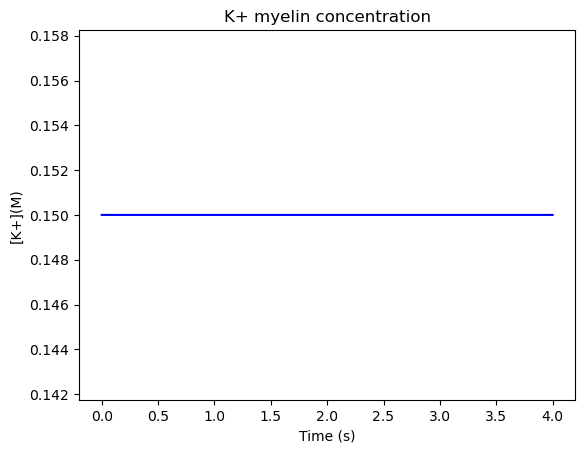

In [29]:
fig,ax=mpl.subplots()
mpl.plot(times, myelinK,color='blue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("[K+](M)")
mpl.title("K+ myelin concentration")
mpl.show()

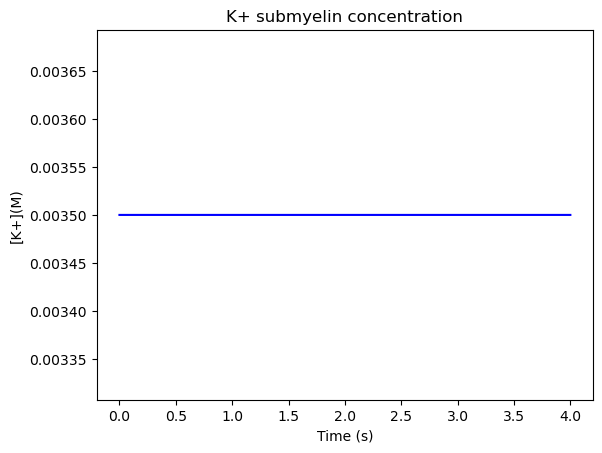

In [30]:
fig,ax=mpl.subplots()
mpl.plot(times, submyelinK,color='blue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("[K+](M)")
mpl.title("K+ submyelin concentration")
mpl.show()

In [15]:
submyelinK = np.full(len(times), Krest)
myelinK = np.full(len(times), Ki)
extK = np.full(len(times),Krest)
atpase_current_K=np.full(len(times),0.)
IKIR_s=np.full(len(times),0.0)
IHCN_s=np.full(len(times),0.0)
IATP_s=np.full(len(times),0.0)

IKIR_e=np.full(len(times),0.0)
IHCN_e=np.full(len(times),0.0)
IATP_e=np.full(len(times),0.0)

EK_s=np.full(len(times),0.)
EK_e=np.full(len(times),0.)

V=np.full(len(times),El)

In [8]:
for i in range(len(times)-1):

    submyelinK[i+1]=submyelinK[i] #on aligne la concentration au pas de temps précedent
    myelinK[i+1]=myelinK[i]

    #AP efflux

    if sum(APtimes < (times[i] - dt)) < sum(APtimes < times[i]):  #meaning that the t+dt is reaching the timing of a new AP
        submyelinK[i + 1] += APefflux  # addition of K+ efflux from the neuronal activity


    #interface submyelin

     #Les courants
    atpase_current=ATPase_2(Imax/20,KmK,KmNa,submyelinK[i],Ni)
    IATP_s[i]=sum(atpase_current)

    ikir= I_KIR(R,T,F,Gk/20,V[i],submyelinK[i],myelinK[i])
    IKIR_s[i]=ikir
    ihcn= I_H(P_openH(a,b,c,V[i],V_half),Gh/20,V[i],gamma,submyelinK[i],myelinK[i])
    IHCN_s[i]=sum(ihcn)


   #Les concentrations K+
    atpase_current_K=atpase_current[1]
    myelinK[i+1] -=  atpase_current_K*dt/(F*V_myelin)
    submyelinK[i+1]+=atpase_current_K*dt/(F*V_submyelin)

    myelinK[i+1]-= ikir * dt / (V_myelin * F)
    submyelinK[i+1]+= ikir * dt / (V_submyelin * F)

    ihcn_k= ihcn[0]
    myelinK[i+1]-= ihcn_k* dt / (V_myelin * F)
    submyelinK[i+1]+= ihcn_k* dt / (V_submyelin * F)

    EK_s[i]=E(R,T,F,submyelinK[i],myelinK[i])
    EK_e[i]=E(R,T,F,Krest,myelinK[i])

  #  V[i + 1] = V[i] + dt / Cm * ( - IKIR_s[i] - IHCN_s[i]-IATP_s[i])




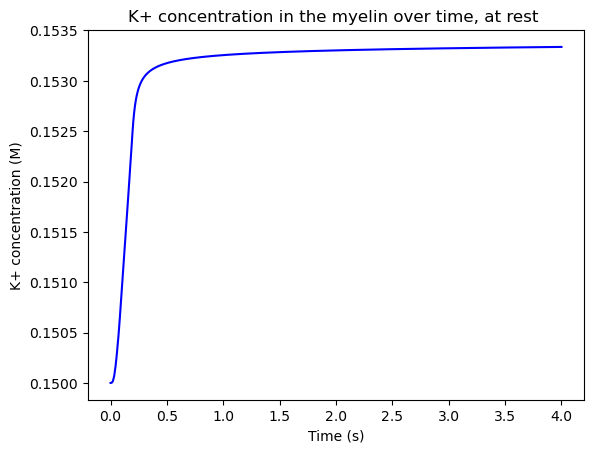

In [9]:

fig,ax=mpl.subplots()
mpl.plot(times, myelinK,color='blue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("K+ concentration (M)")
mpl.title("K+ concentration in the myelin over time, at rest ")
mpl.show()


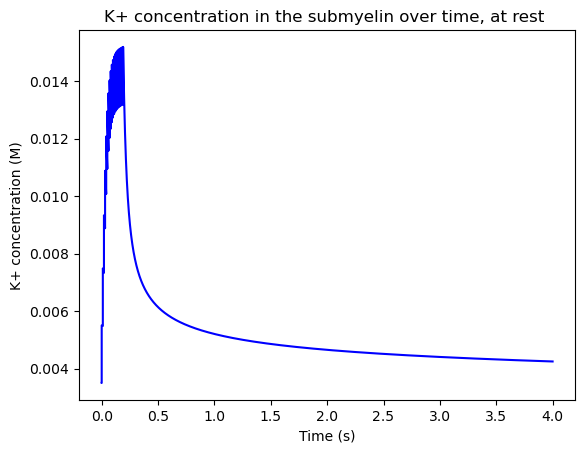

In [10]:
fig,ax=mpl.subplots()
mpl.plot(times, submyelinK,color='blue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("K+ concentration (M)")
mpl.title("K+ concentration in the submyelin over time, at rest ")
mpl.show()

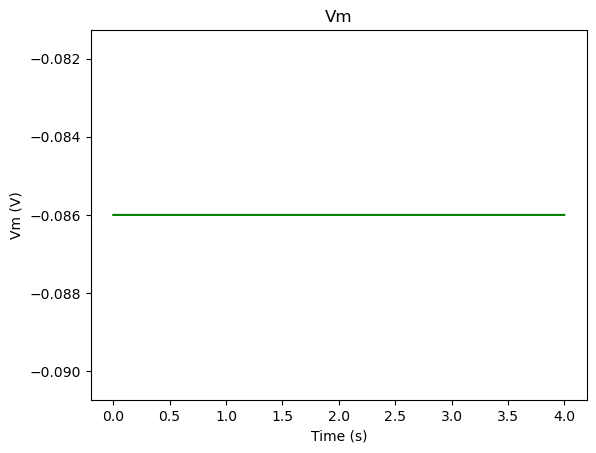

In [11]:

fig,ax=mpl.subplots()
mpl.plot(times, V,color='green')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vm (V)")
mpl.title("Vm")
mpl.show()


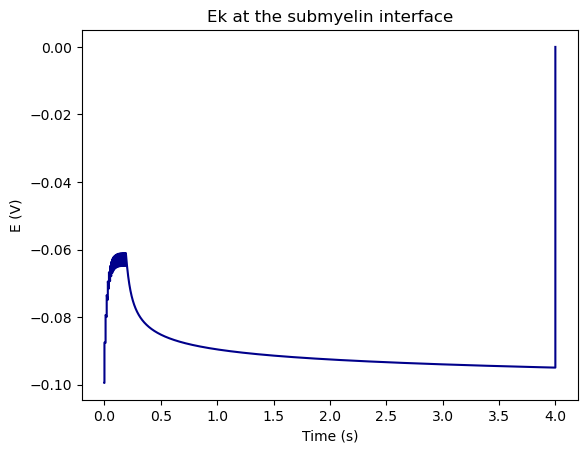

In [12]:
fig,ax=mpl.subplots()
mpl.plot(times, EK_s,color='darkblue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("E (V)")
mpl.title("Ek at the submyelin interface")
mpl.show()

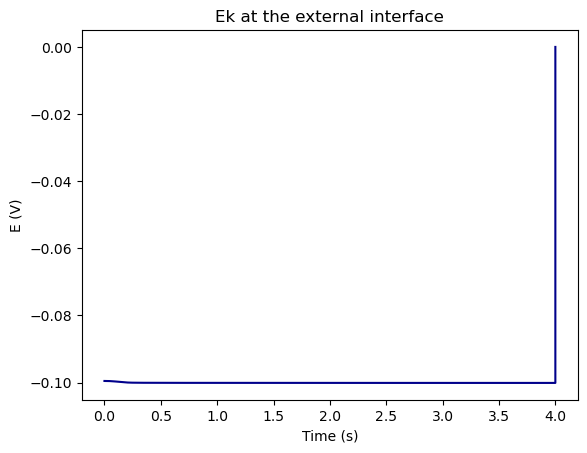

In [13]:
’fig,ax=mpl.subplots()
mpl.plot(times, EK_e,color='darkblue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("E (V)")
mpl.title("Ek at the external interface")
mpl.show()

In [16]:
for i in range(len(times)-1):

    submyelinK[i+1]=submyelinK[i] #on aligne la concentration au pas de temps précedent
    myelinK[i+1]=myelinK[i]

    #AP efflux

    if sum(APtimes < (times[i] - dt)) < sum(APtimes < times[i]):  #meaning that the t+dt is reaching the timing of a new AP
        submyelinK[i + 1] += APefflux  # addition of K+ efflux from the neuronal activity


    #interface submyelin

     #Les courants
    atpase_current=ATPase_2(Imax/20,KmK,KmNa,submyelinK[i],Ni)
    IATP_s[i]=sum(atpase_current)

    ikir= I_KIR(R,T,F,Gk/20,V[i],submyelinK[i],myelinK[i])
    IKIR_s[i]=ikir
    ihcn= I_H(P_openH(a,b,c,V[i],V_half),Gh/20,V[i],gamma,submyelinK[i],myelinK[i])
    IHCN_s[i]=sum(ihcn)


   #Les concentrations K+
    atpase_current_K=atpase_current[1]
    myelinK[i+1] -=  atpase_current_K*dt/(F*V_myelin)
    submyelinK[i+1]+=atpase_current_K*dt/(F*V_submyelin)

    myelinK[i+1]-= ikir * dt / (V_myelin * F)
    submyelinK[i+1]+= ikir * dt / (V_submyelin * F)

    ihcn_k= ihcn[0]
    myelinK[i+1]-= ihcn_k* dt / (V_myelin * F)
    submyelinK[i+1]+= ihcn_k* dt / (V_submyelin * F)



    #interface ext

     #Les courants
    atpase_current=ATPase_2(Imax/20,KmK,KmNa,Krest,Ni)
    IATP_e[i]=sum(atpase_current)

    ikir= I_KIR(R,T,F,Gk/20,V[i],Krest,myelinK[i])
    IKIR_e[i]=ikir
    ihcn= I_H(P_openH(a,b,c,V[i],V_half),Gh/20,V[i],gamma,Krest,myelinK[i])
    IHCN_e[i]=sum(ihcn)


   #Les concentrations K+
    atpase_current_K=atpase_current[1]
    myelinK[i+1] -=  atpase_current_K*dt/(F*V_myelin)

    myelinK[i+1]-= ikir * dt / (V_myelin * F)

    ihcn_k= ihcn[0]
    myelinK[i+1]-= ihcn_k* dt / (V_myelin * F)



    V[i + 1] = V[i] + dt / Cm * ( - IKIR_s[i] - IHCN_s[i]-IATP_s[i]-IKIR_e[i] - IHCN_e[i]-IATP_e[i])



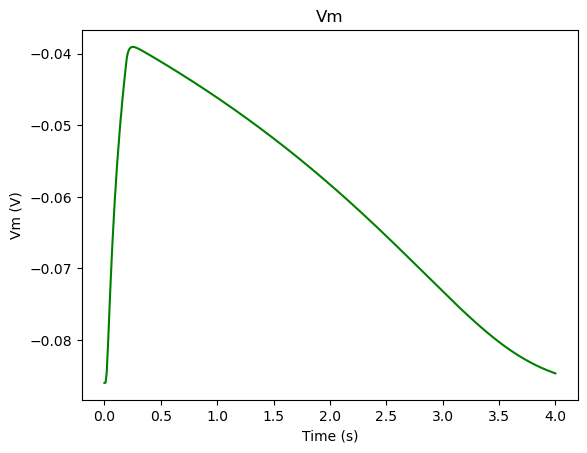

In [17]:
fig,ax=mpl.subplots()
mpl.plot(times, V,color='green')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vm (V)")
mpl.title("Vm")
mpl.show()

/Users/lounaschaison/miniforge3/envs/basepython/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


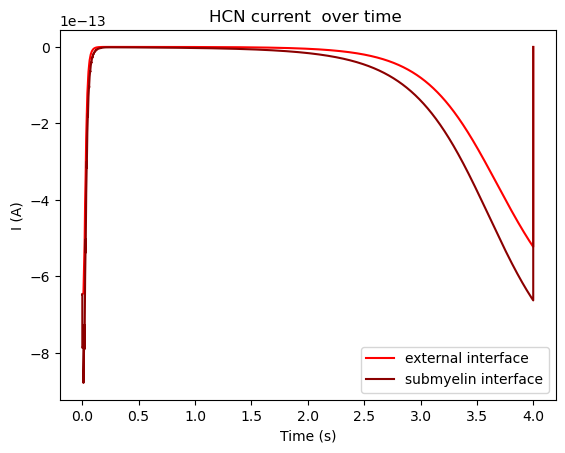

In [20]:
fig,ax=mpl.subplots()
mpl.plot(times, IHCN_e,color='red',label="external interface")
mpl.plot(times, IHCN_s,color='darkred', label='submyelin interface')
ax.set_xlabel("Time (s)")
ax.set_ylabel("I (A)")
mpl.title("HCN current  over time ")
mpl.legend()
mpl.show()

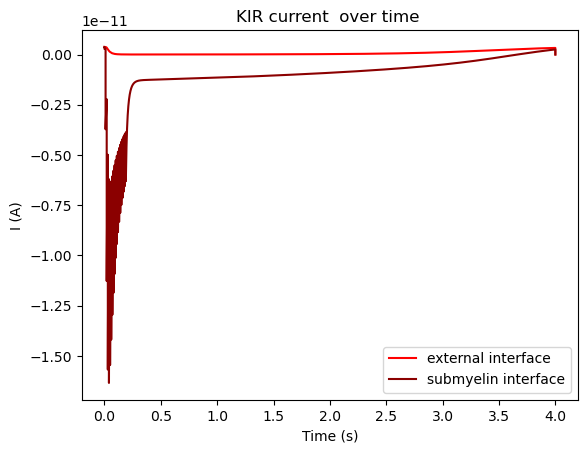

In [21]:
fig,ax=mpl.subplots()
mpl.plot(times, IKIR_e,color='red',label="external interface")
mpl.plot(times, IKIR_s,color='darkred', label='submyelin interface')
ax.set_xlabel("Time (s)")
ax.set_ylabel("I (A)")
mpl.title("KIR current  over time ")
mpl.legend()
mpl.show()

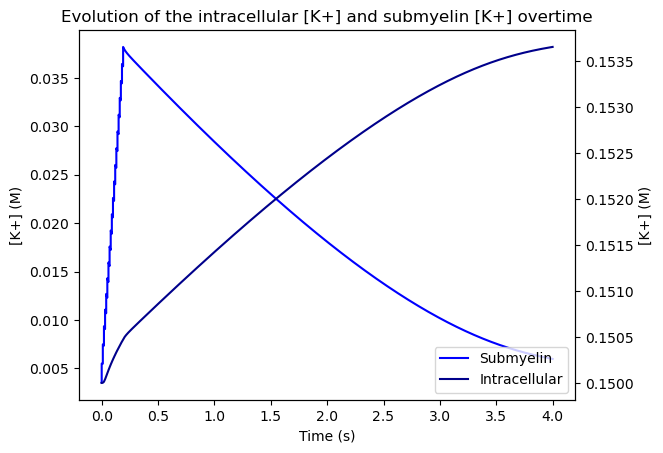

In [28]:

fig, ax1 = mpl.subplots()

line1 = ax1.plot(times, submyelinK, color='blue', label="Submyelin")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("[K+] (M)",color='blue')
ax2 = ax1.twinx()
line2 = ax2.plot(times, myelinK, color='darkblue', label="Intracellular")
ax2.set_ylabel("[K+] (M)",color='darkblue')

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower right')

mpl.title("Evolution of the intracellular [K+] and submyelin [K+] overtime")

mpl.show()

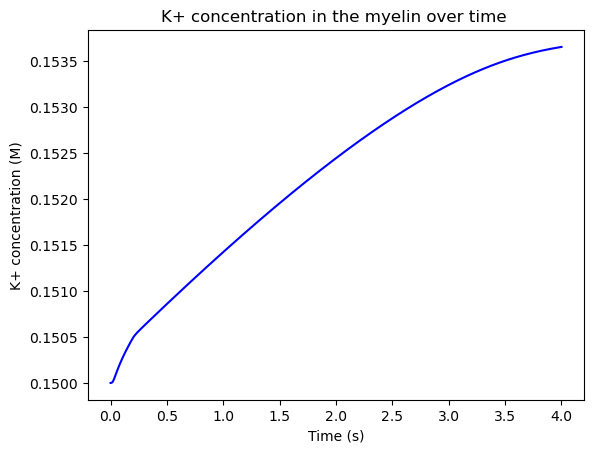

In [18]:
fig,ax=mpl.subplots()
mpl.plot(times, myelinK,color='blue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("K+ concentration (M)")
mpl.title("K+ concentration in the myelin over time ")
mpl.show()

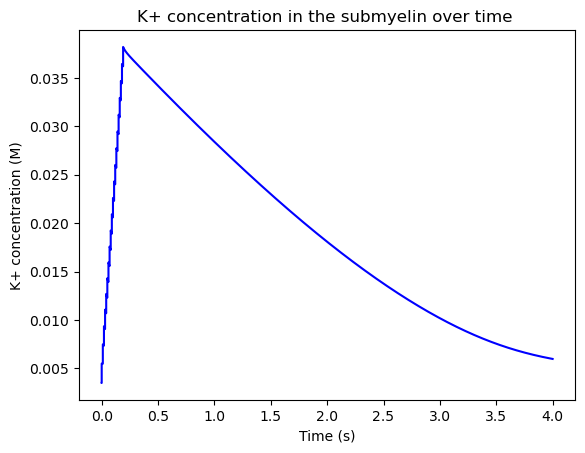

In [19]:
fig,ax=mpl.subplots()
mpl.plot(times, submyelinK,color='blue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("K+ concentration (M)")
mpl.title("K+ concentration in the submyelin over time ")
mpl.show()